In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import display

In [2]:
base_path = r"D:\Jupyter notebook\files\Optimization\MKF-master\data"
robot_num = 1  # Номер робота (1-5)

landmark_file = f"{base_path}/Landmark_Groundtruth.csv"
landmark = pd.read_csv(landmark_file, sep="\s+", header=None,
                      names=['id', 'x', 'y', 'std_x', 'std_y'])
print(f"Загружено {len(landmark)} маркеров")


groundtruth_file = f"{base_path}/Robot{robot_num}_Groundtruth.csv"
groundtruth = pd.read_csv(groundtruth_file, sep="\s+", header=None,
                         names=['time', 'x', 'y', 'yaw'])

odometry_file = f"{base_path}/Robot{robot_num}_Odometry.csv"
odometry = pd.read_csv(odometry_file, sep="\s+", header=None,
                      names=['time', 'v', 'w'])

measurement_file = f"{base_path}/Robot{robot_num}_Measurement.csv"
measurements = pd.read_csv(measurement_file, sep="\s+", header=None,
                          names=['time', 'id', 'range', 'bearing'])


Загружено 15 маркеров


In [10]:
# Нормализация времени (делаем время относительным)
base_time = odometry['time'].iloc[0]
odometry['time'] -= base_time
groundtruth['time'] -= base_time
measurements['time'] -= base_time

# Создание карты маркеров (из C++ кода)
barcode_map = {
    23: 5, 72: 6, 27: 7, 54: 8, 70: 9, 36: 10,
    18: 11, 25: 12, 9: 13, 81: 14, 16: 15, 90: 16,
    61: 17, 45: 18, 7: 19, 63: 20
}


filtered_ids = [5, 14, 41, 32, 23] 
valid_measurements = measurements[~measurements['id'].isin(filtered_ids)]
valid_measurements = valid_measurements[valid_measurements['time'] >= 0]  

# 2.4 Сопоставление ID маркеров
valid_measurements['subject'] = valid_measurements['id'].map(barcode_map)
valid_measurements = valid_measurements.dropna()  


def normalize_angle(angle):
    """Нормализация угла в диапазон [-π, π]"""
    return (angle + np.pi) % (2 * np.pi) - np.pi

landmark_dict = {row.id: {'x': row.x, 'y': row.y} for row in landmark.itertuples()}

true_values = []
for _, meas in tqdm(valid_measurements.iterrows(), total=len(valid_measurements)):
    time_diff = np.abs(groundtruth['time'] - meas['time'])
    closest_idx = time_diff.idxmin()
    gt = groundtruth.iloc[closest_idx]
    
    lm = landmark_dict.get(meas['subject'])
    if lm is None:
        continue
    
    dx = lm['x'] - gt['x']
    dy = lm['y'] - gt['y']
    true_range = np.hypot(dx, dy)
    true_bearing = normalize_angle(np.arctan2(dy, dx) - gt['yaw'])
    
    true_values.append({
        'true_range': true_range,
        'true_bearing': true_bearing
    })

true_df = pd.DataFrame(true_values)
measurements_updated = pd.concat([valid_measurements.reset_index(drop=True), true_df], axis=1)

100%|████████████████████████████████████████████████████████████████████████████| 4771/4771 [00:02<00:00, 2064.90it/s]


In [12]:
output_file = f"{base_path}/Robot{robot_num}_Measurement_updated.csv"
measurements_updated.to_csv(output_file, index=False)
print(f"\nОбработанные данные сохранены в: {output_file}")


Обработанные данные сохранены в: D:\Jupyter notebook\files\Optimization\MKF-master\data/Robot1_Measurement_updated.csv


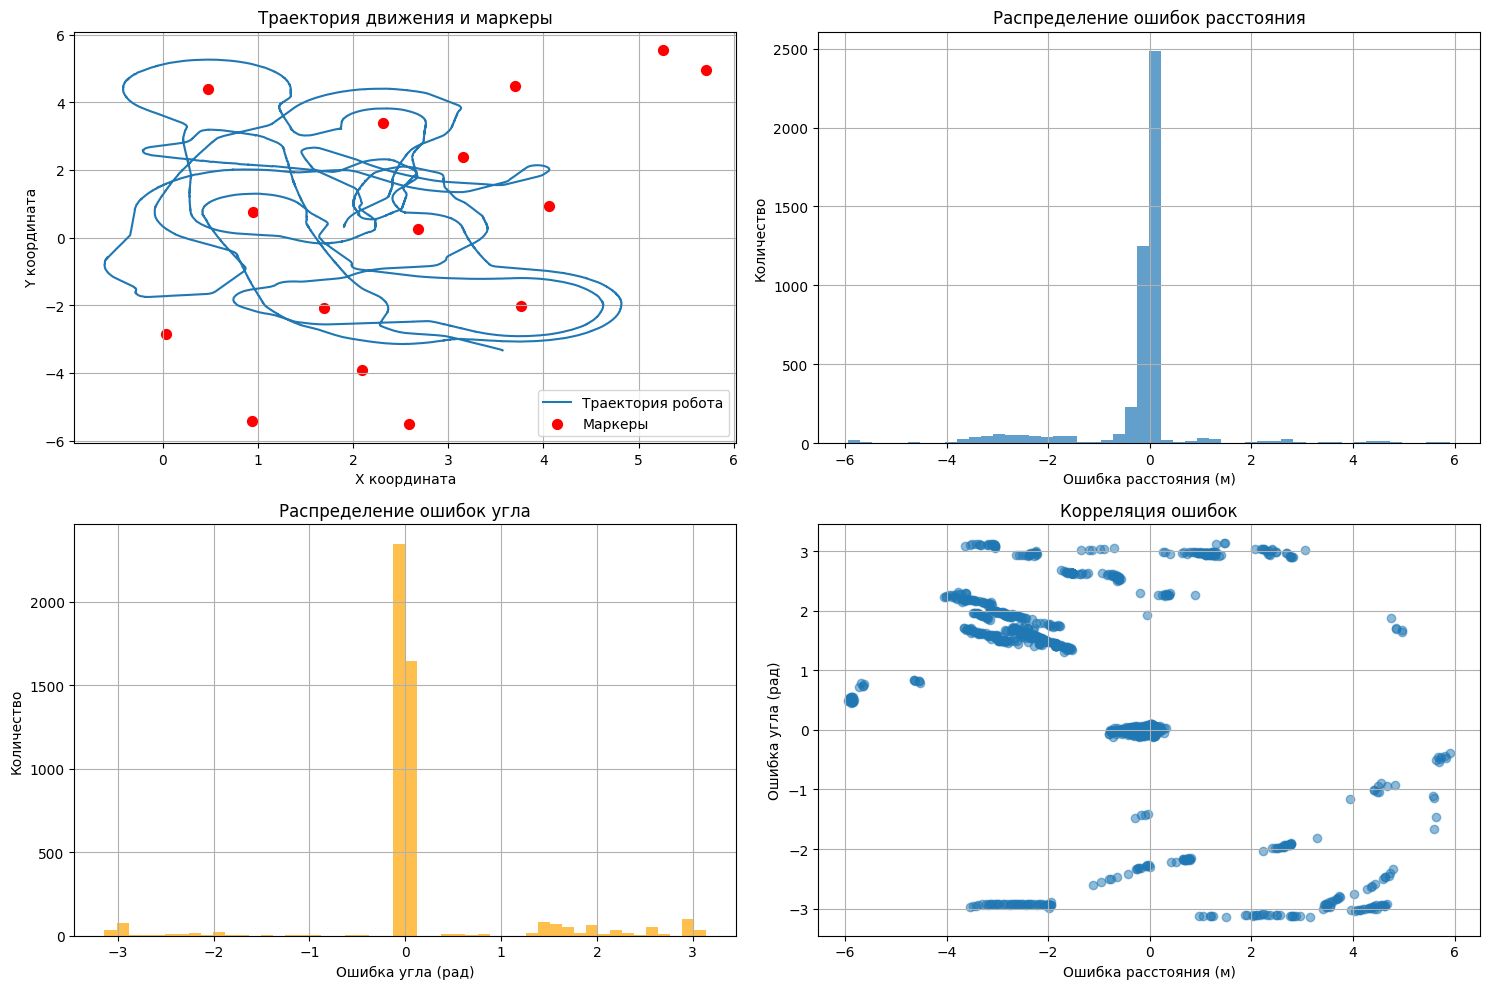


Статистика ошибок измерений:
             Метрика  Ошибка расстояния (м)  Ошибка угла (рад)
0            Среднее              -0.180043           0.136486
1  Станд. отклонение               1.135660           0.910433
2           Максимум               5.905782           3.140089
3            Минимум              -5.935586          -3.138620


In [4]:

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(groundtruth['x'], groundtruth['y'], label='Траектория робота')
plt.scatter(landmark['x'], landmark['y'], c='red', s=50, label='Маркеры')
plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.title('Траектория движения и маркеры')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
errors_range = processed_data['range'] - processed_data['true_range']
plt.hist(errors_range, bins=50, alpha=0.7)
plt.xlabel('Ошибка расстояния (м)')
plt.ylabel('Количество')
plt.title('Распределение ошибок расстояния')
plt.grid(True)

plt.subplot(2, 2, 3)
errors_bearing = processed_data['bearing'] - processed_data['true_bearing']
errors_bearing = normalize_angle(errors_bearing)  # Нормализуем углы
plt.hist(errors_bearing, bins=50, alpha=0.7, color='orange')
plt.xlabel('Ошибка угла (рад)')
plt.ylabel('Количество')
plt.title('Распределение ошибок угла')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.scatter(errors_range, errors_bearing, alpha=0.5)
plt.xlabel('Ошибка расстояния (м)')
plt.ylabel('Ошибка угла (рад)')
plt.title('Корреляция ошибок')
plt.grid(True)

plt.tight_layout()
plt.show()


print("\nСтатистика ошибок измерений:")
stats = pd.DataFrame({
    'Метрика': ['Среднее', 'Станд. отклонение', 'Максимум', 'Минимум'],
    'Ошибка расстояния (м)': [
        errors_range.mean(),
        errors_range.std(),
        errors_range.max(),
        errors_range.min()
    ],
    'Ошибка угла (рад)': [
        errors_bearing.mean(),
        errors_bearing.std(),
        errors_bearing.max(),
        errors_bearing.min()
    ]
})
print(stats)

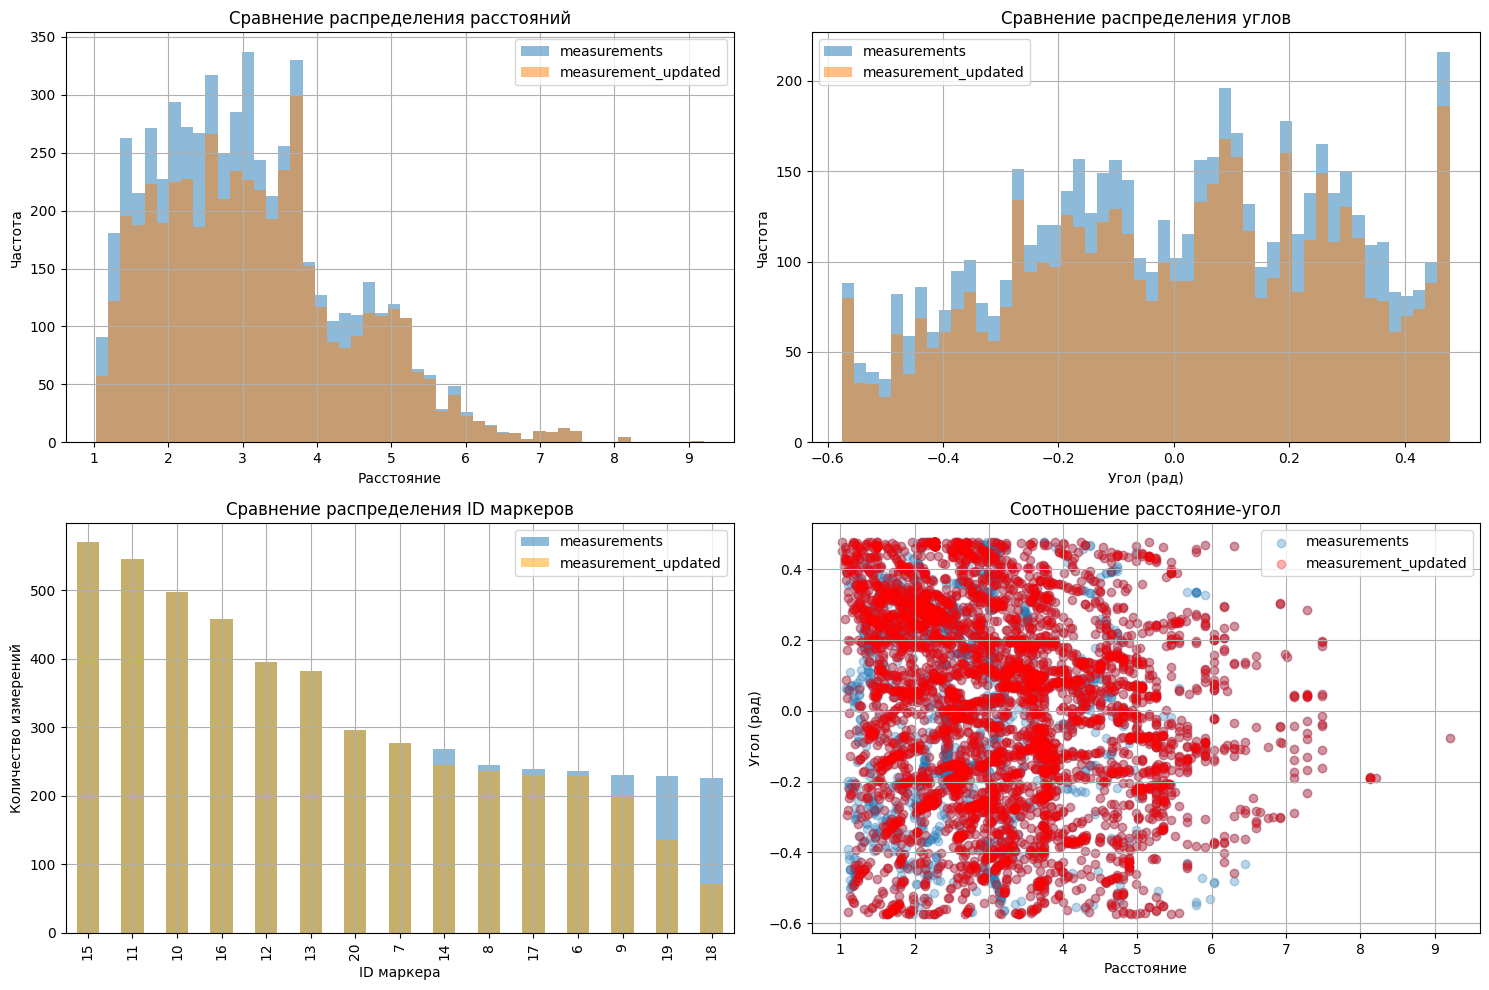


=== Удаленные ID маркеров ===
{32, 36, 70, 72, 41, 45, 81, 54, 23, 25, 90, 27, 61, 63}

Статистика удаленных измерений:
Всего удалено: 3864
Распределение по ID:
id
36    497
90    459
25    395
63    296
27    278
32    269
81    245
41    239
54    237
61    230
72    229
23    218
70    201
45     71
Name: count, dtype: int64

=== Анализ ошибок измерений ===


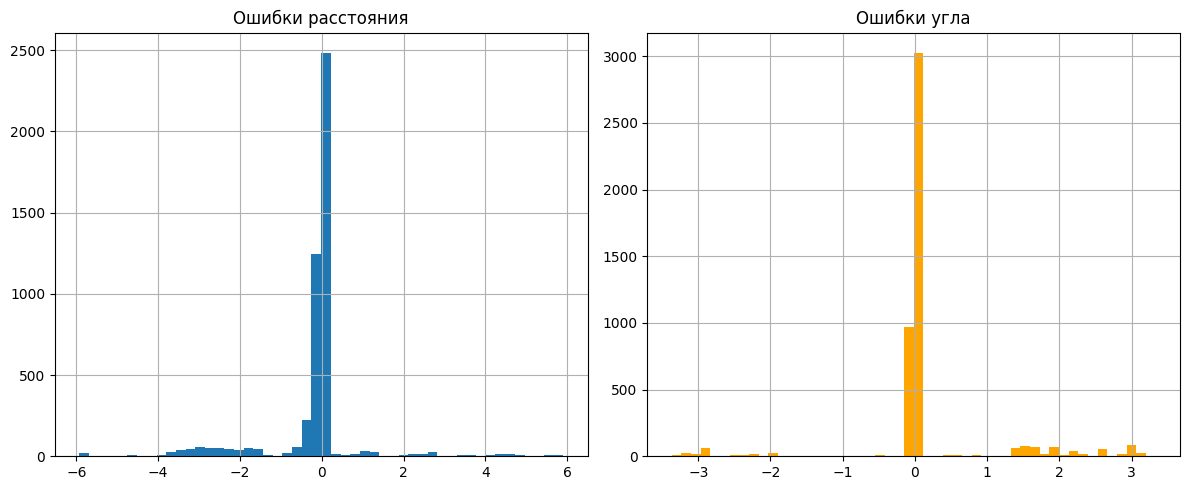


Статистика ошибок:
Средняя ошибка расстояния: -0.1800 ± 1.1357 м
Средняя ошибка угла: 0.1273 ± 0.9165 рад


In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(measurements['range'], bins=50, alpha=0.5, label='measurements')
plt.hist(measurement_updated['range'], bins=50, alpha=0.5, label='measurement_updated')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.title('Сравнение распределения расстояний')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(measurements['bearing'], bins=50, alpha=0.5, label='measurements')
plt.hist(measurement_updated['bearing'], bins=50, alpha=0.5, label='measurement_updated')
plt.xlabel('Угол (рад)')
plt.ylabel('Частота')
plt.title('Сравнение распределения углов')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
measurements['id'].value_counts().plot(kind='bar', alpha=0.5, label='measurements')
measurement_updated['subject'].value_counts().plot(kind='bar', alpha=0.5, color='orange', label='measurement_updated')
plt.xlabel('ID маркера')
plt.ylabel('Количество измерений')
plt.title('Сравнение распределения ID маркеров')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.scatter(measurements['range'], measurements['bearing'], alpha=0.3, label='measurements')
plt.scatter(measurement_updated['range'], measurement_updated['bearing'], alpha=0.3, color='red', label='measurement_updated')
plt.xlabel('Расстояние')
plt.ylabel('Угол (рад)')
plt.title('Соотношение расстояние-угол')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

original_ids = set(measurements['id'])
updated_ids = set(measurement_updated['subject'])
removed_ids = original_ids - updated_ids

print("\n=== Удаленные ID маркеров ===")
print(removed_ids)

removed_data = measurements[measurements['id'].isin(removed_ids)]
print("\nСтатистика удаленных измерений:")
print(f"Всего удалено: {len(removed_data)}")
print("Распределение по ID:")
print(removed_data['id'].value_counts())

if {'true_range', 'true_bearing'}.issubset(measurement_updated.columns):
    print("\n=== Анализ ошибок измерений ===")
    errors_range = measurement_updated['range'] - measurement_updated['true_range']
    errors_bearing = measurement_updated['bearing'] - measurement_updated['true_bearing']
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(errors_range, bins=50)
    plt.title('Ошибки расстояния')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.hist(errors_bearing, bins=50, color='orange')
    plt.title('Ошибки угла')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nСтатистика ошибок:")
    print(f"Средняя ошибка расстояния: {errors_range.mean():.4f} ± {errors_range.std():.4f} м")
    print(f"Средняя ошибка угла: {errors_bearing.mean():.4f} ± {errors_bearing.std():.4f} рад")